In [30]:
import pyreadr as py
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers.core import Dense, Dropout

Using TensorFlow backend.


ImportError: Traceback (most recent call last):
  File "/home/mark.lyubimov/.local/share/virtualenvs/tep-EqsBjobE/lib/python3.6/site-packages/tensorflow/python/pywrap_tensorflow.py", line 58, in <module>
    from tensorflow.python.pywrap_tensorflow_internal import *
  File "/home/mark.lyubimov/.local/share/virtualenvs/tep-EqsBjobE/lib/python3.6/site-packages/tensorflow/python/pywrap_tensorflow_internal.py", line 28, in <module>
    _pywrap_tensorflow_internal = swig_import_helper()
  File "/home/mark.lyubimov/.local/share/virtualenvs/tep-EqsBjobE/lib/python3.6/site-packages/tensorflow/python/pywrap_tensorflow_internal.py", line 24, in swig_import_helper
    _mod = imp.load_module('_pywrap_tensorflow_internal', fp, pathname, description)
  File "/home/mark.lyubimov/.local/share/virtualenvs/tep-EqsBjobE/lib/python3.6/imp.py", line 243, in load_module
    return load_dynamic(name, filename, file)
  File "/home/mark.lyubimov/.local/share/virtualenvs/tep-EqsBjobE/lib/python3.6/imp.py", line 343, in load_dynamic
    return _load(spec)
ImportError: /home/mark.lyubimov/.local/share/virtualenvs/tep-EqsBjobE/lib/python3.6/site-packages/tensorflow/python/_pywrap_tensorflow_internal.so: invalid ELF header


Failed to load the native TensorFlow runtime.

See https://www.tensorflow.org/install/install_sources#common_installation_problems

for some common reasons and solutions.  Include the entire stack trace
above this error message when asking for help.

> ### Data downloading
Data link  
https://dataverse.harvard.edu/dataset.xhtml?persistentId=doi:10.7910/DVN/6C3JR1

##### Data description
Here we consoder dataset of "Additional Tennessee Eastman Process Simulation Data for Anomaly Detection Evaluation"
This dataverse contains the data referenced in Rieth et al. (2017). Issues and Advances in Anomaly Detection Evaluation for Joint Human-Automated Systems. To be presented at Applied Human Factors and Ergonomics 2017.
##### Columns description
* **faultNumber** ranges from 1 to 20 in the “Faulty” datasets and represents the fault type in the TEP. The “FaultFree” datasets only contain fault 0 (i.e. normal operating conditions).
* **simulationRun** ranges from 1 to 500 and represents a different random number generator state from which a full TEP dataset was generated (Note: the actual seeds used to generate training and testing datasets were non-overlapping).
* **sample** ranges either from 1 to 500 (“Training” datasets) or 1 to 960 (“Testing” datasets). The TEP variables (columns 4 to 55) were sampled every 3 minutes for a total duration of 25 hours and 48 hours respectively. Note that the faults were introduced 1 and 8 hours into the Faulty Training and Faulty Testing datasets, respectively.
* **columns 4-55** contain the process variables; the column names retain the original variable names.

In [2]:
# ! unzip dataverse_files.zip -d dataverse_files

In [3]:
#reading train data in .R format
a1 = py.read_r("dataverse_files/TEP_FaultFree_Training.RData")
a2 = py.read_r("dataverse_files/TEP_Faulty_Training.RData")

In [4]:
#reading test data in .R format
a3 = py.read_r("dataverse_files/TEP_FaultFree_Testing.RData")
a4 = py.read_r("dataverse_files/TEP_Faulty_Testing.RData")

In [5]:
print("Objects that are present in a1 :", a1.keys())
print("Objects that are present in a2 :", a2.keys())
print("Objects that are present in a3 :", a3.keys())
print("Objects that are present in a4 :", a4.keys())

Objects that are present in a1 : odict_keys(['fault_free_training'])
Objects that are present in a2 : odict_keys(['faulty_training'])
Objects that are present in a3 : odict_keys(['fault_free_testing'])
Objects that are present in a4 : odict_keys(['faulty_testing'])


In [6]:
# concatinating the train and the test dataset

# train dataframe
raw_train = pd.concat([a1['fault_free_training'], a2['faulty_training']])
# test dataframe
raw_test = pd.concat([a3['fault_free_testing'], a4['faulty_testing']])

In [7]:
raw_train.groupby(['faultNumber','simulationRun']).size()

faultNumber  simulationRun
0.0          1.0              500
             2.0              500
             3.0              500
             4.0              500
             5.0              500
                             ... 
20.0         496.0            500
             497.0            500
             498.0            500
             499.0            500
             500.0            500
Length: 10500, dtype: int64

In [8]:
raw_test.groupby(['faultNumber','simulationRun']).size()

faultNumber  simulationRun
0            1.0              960
             2.0              960
             3.0              960
             4.0              960
             5.0              960
                             ... 
20           496.0            960
             497.0            960
             498.0            960
             499.0            960
             500.0            960
Length: 10500, dtype: int64

> ### EDA

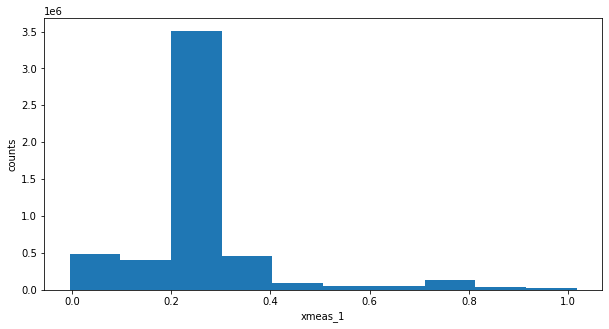

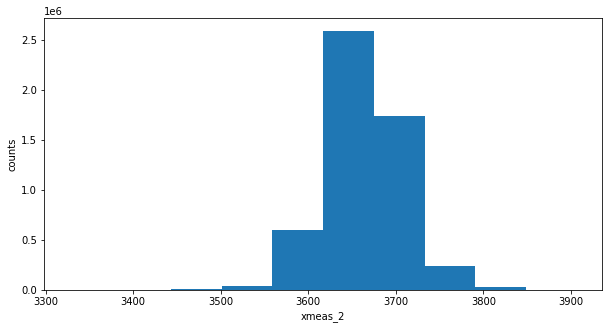

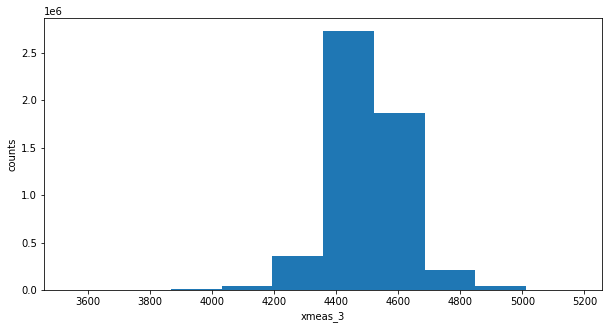

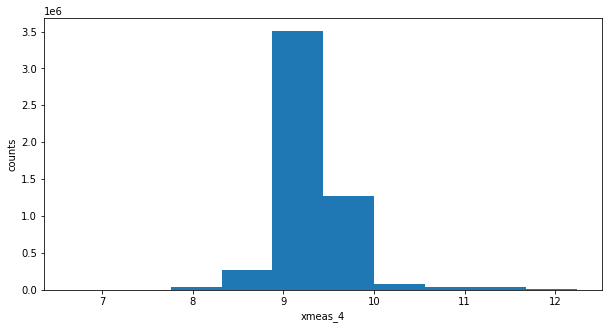

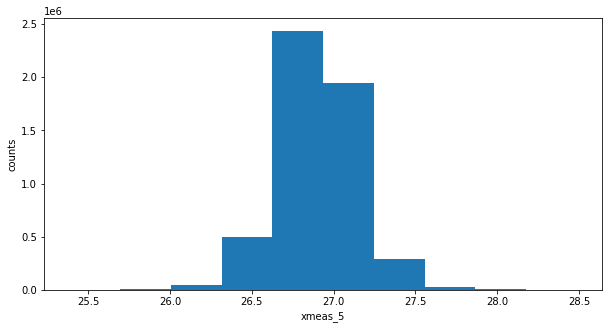

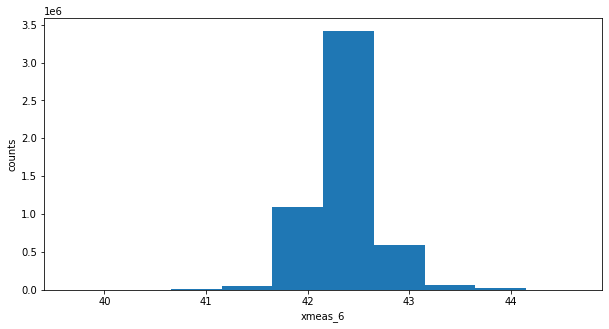

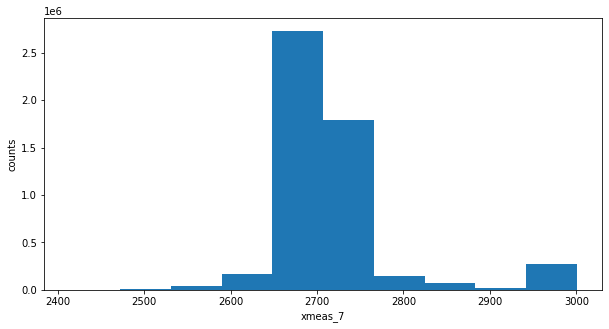

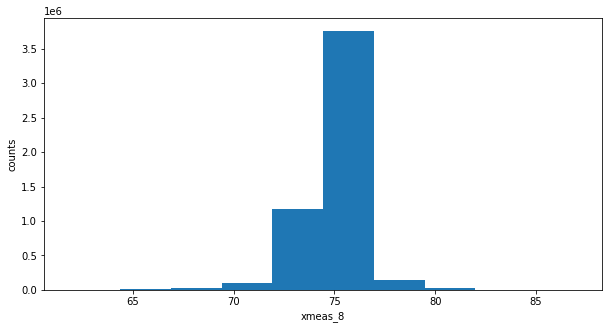

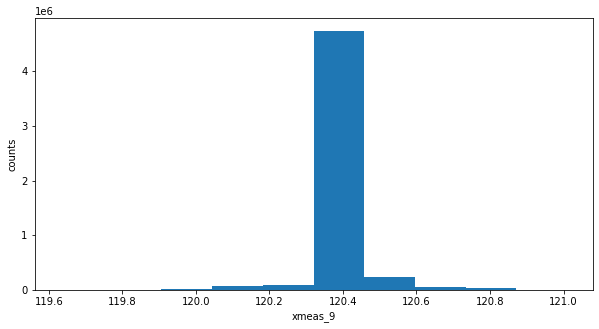

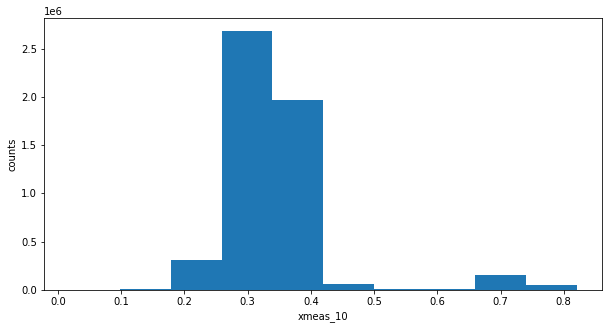

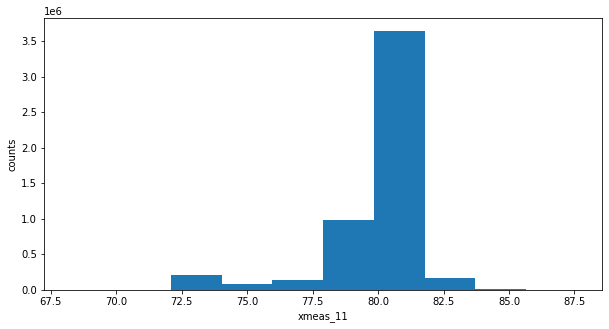

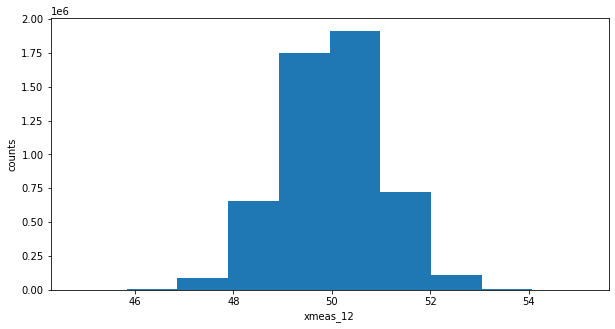

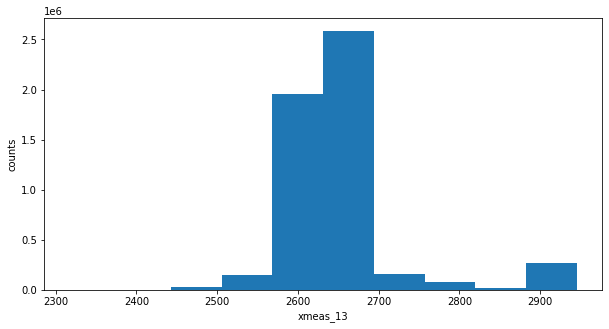

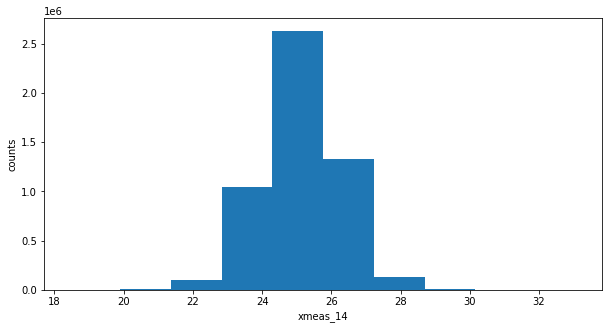

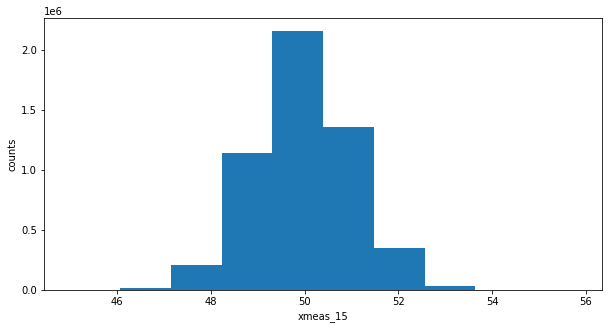

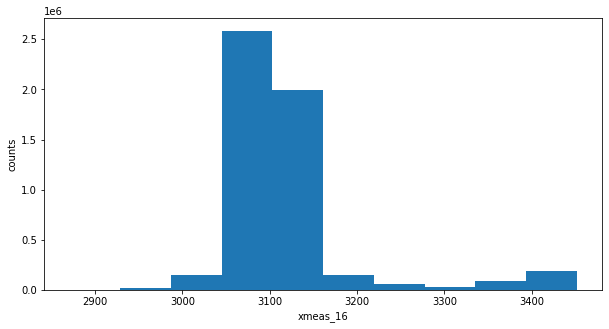

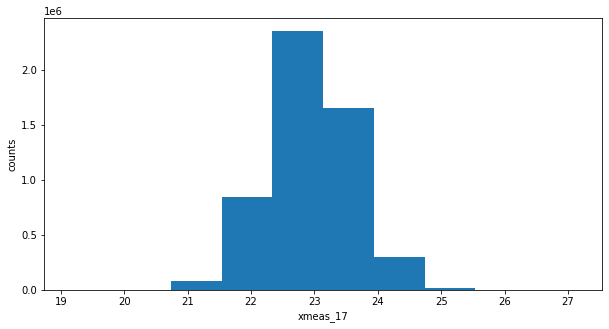

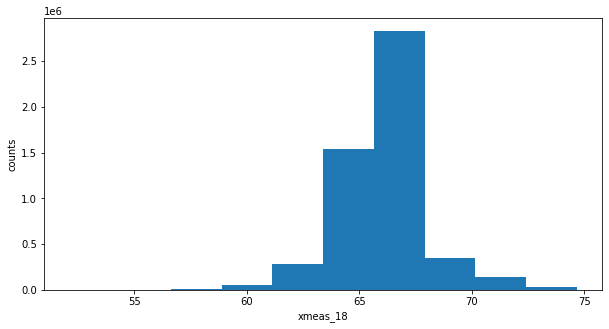

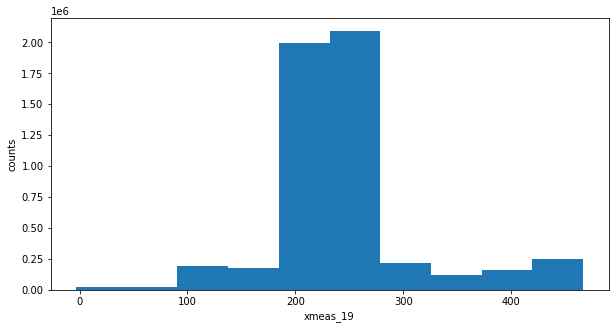

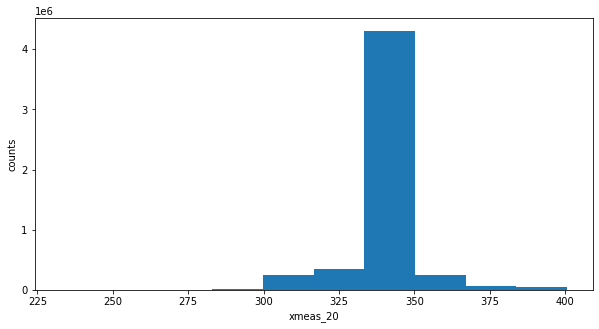

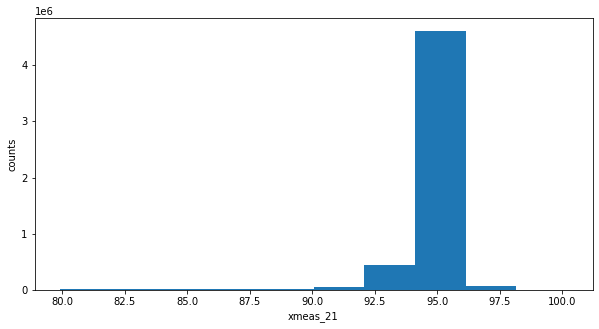

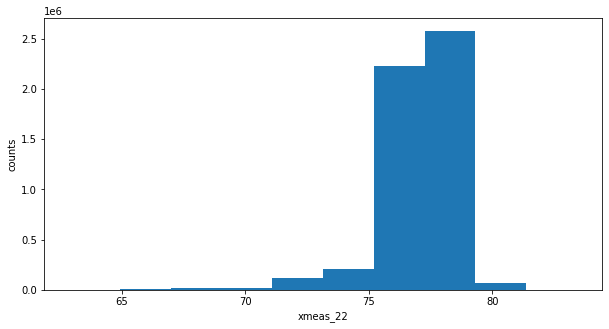

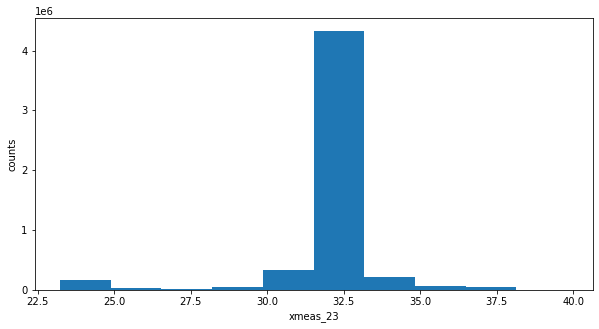

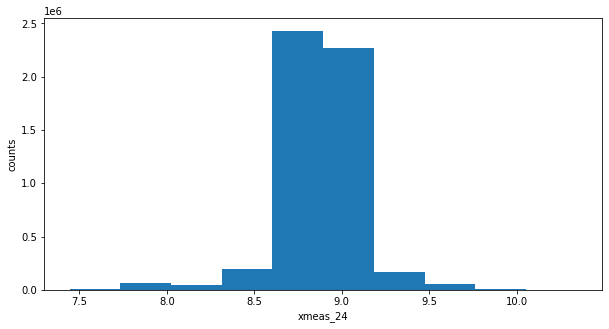

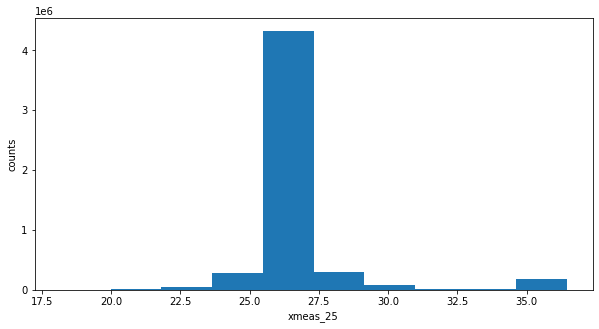

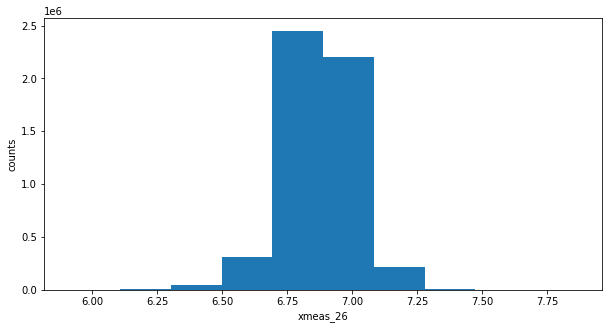

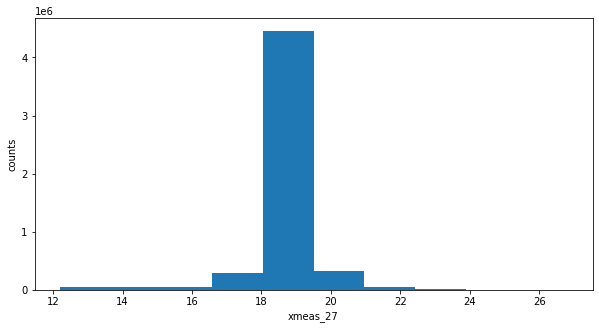

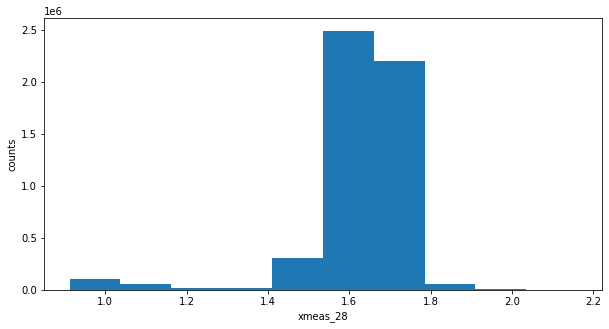

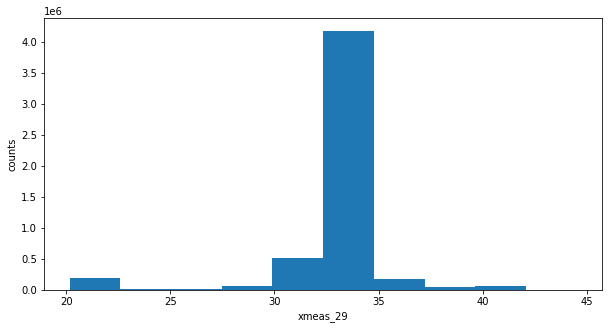

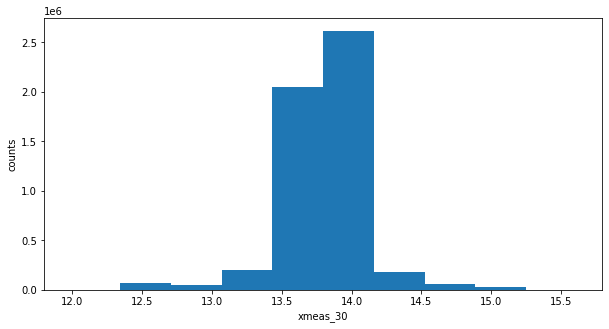

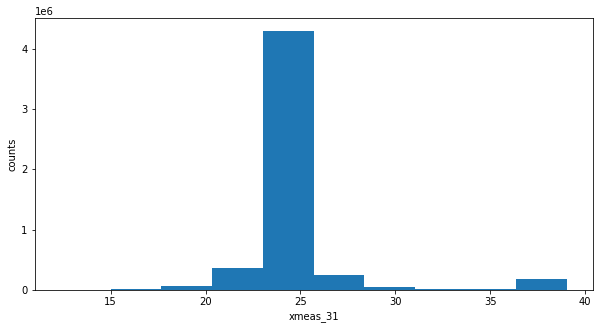

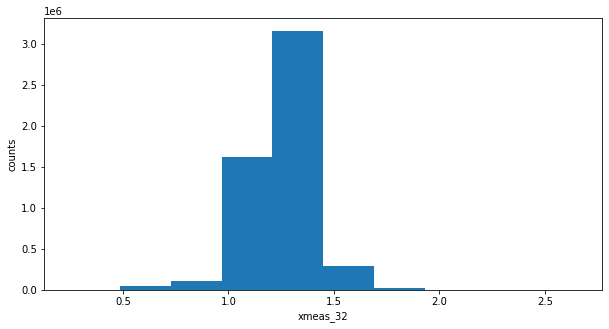

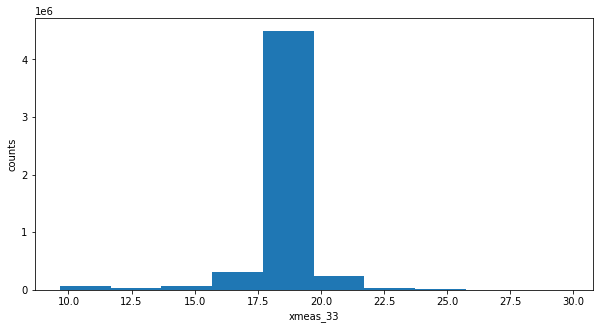

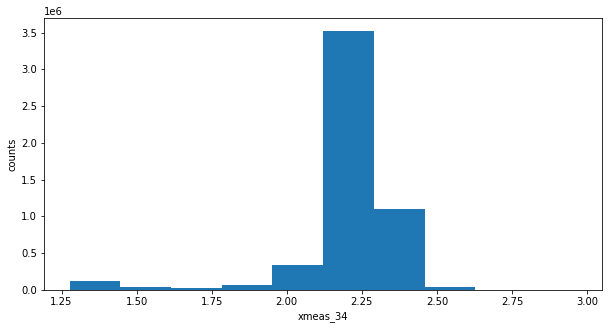

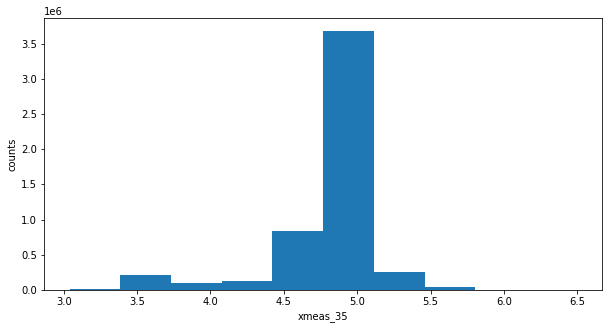

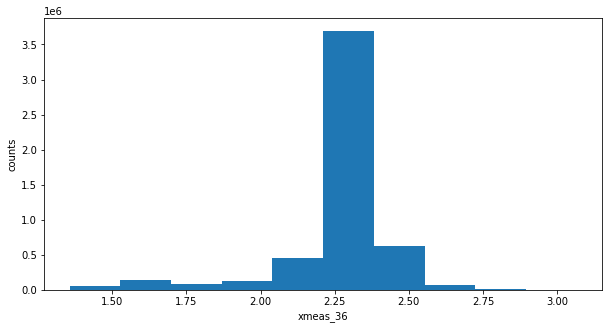

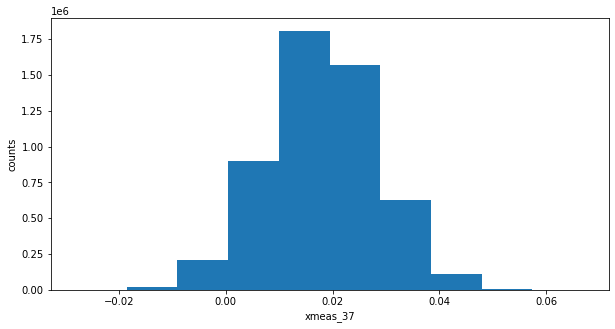

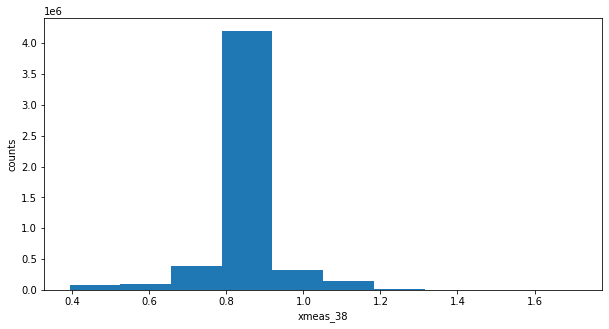

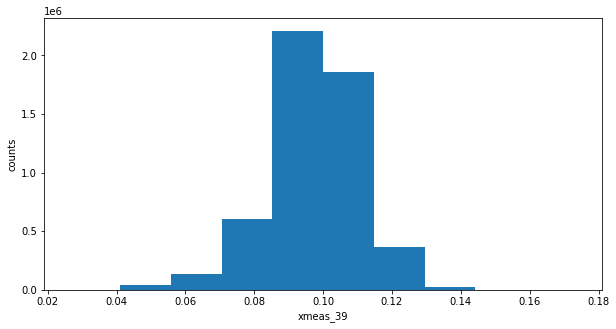

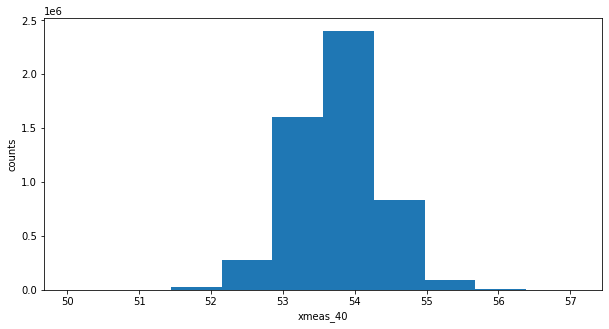

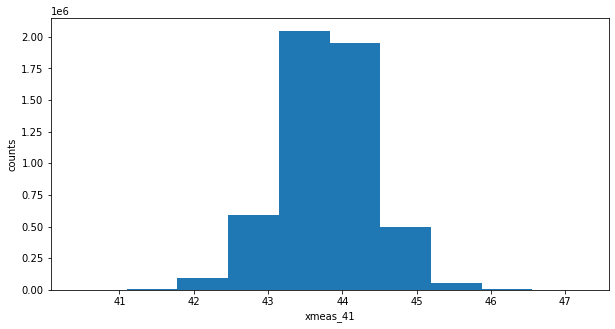

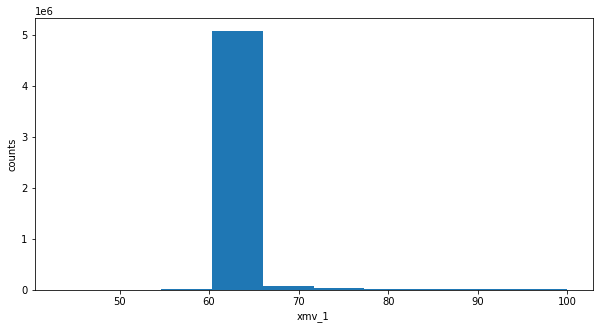

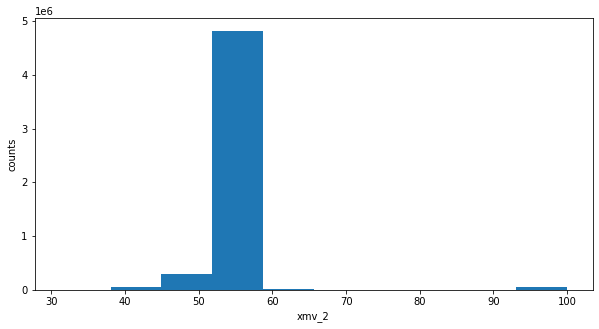

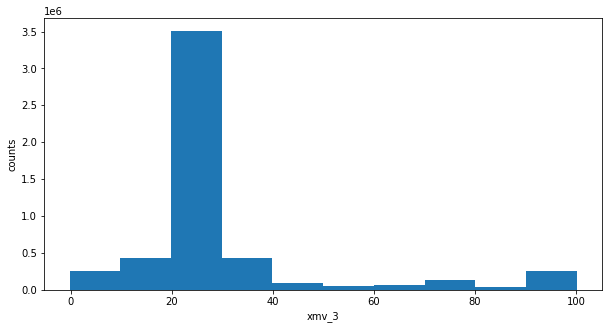

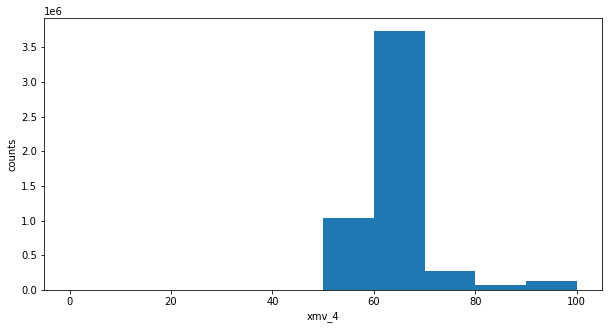

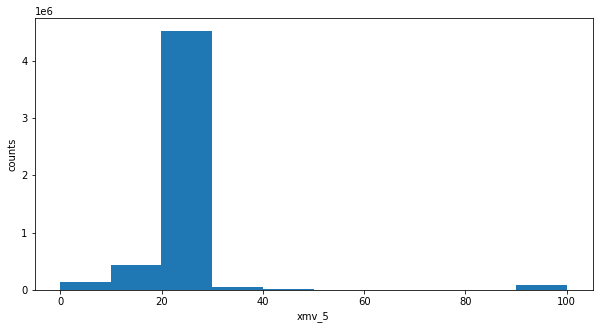

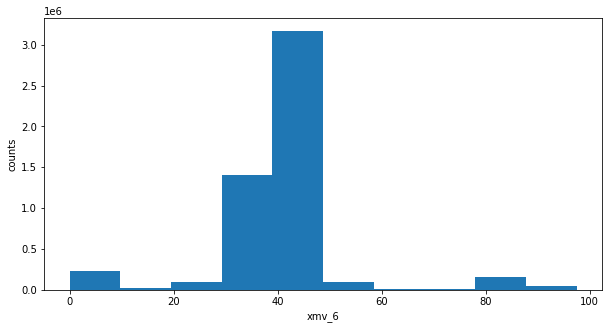

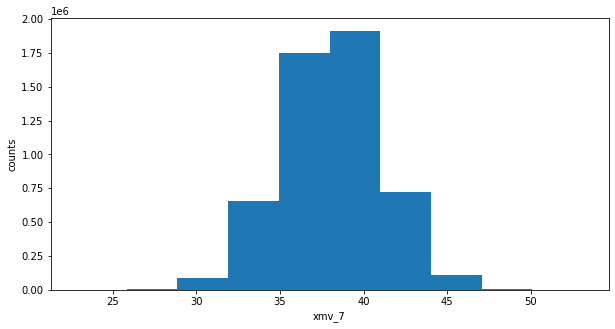

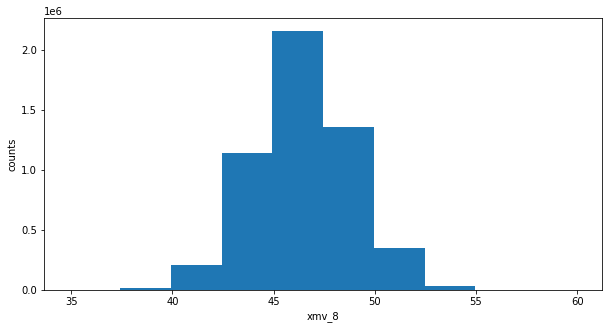

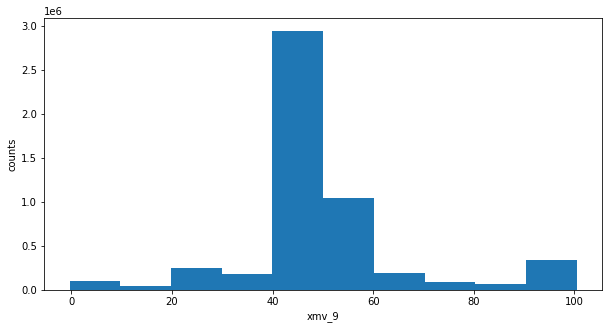

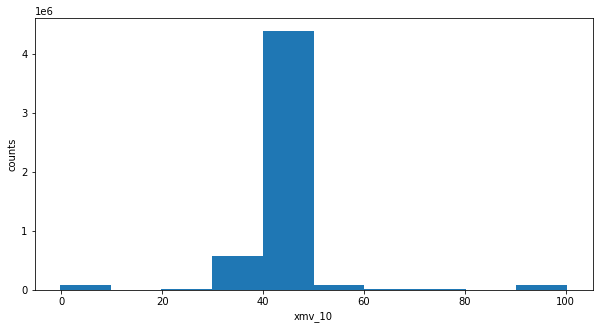

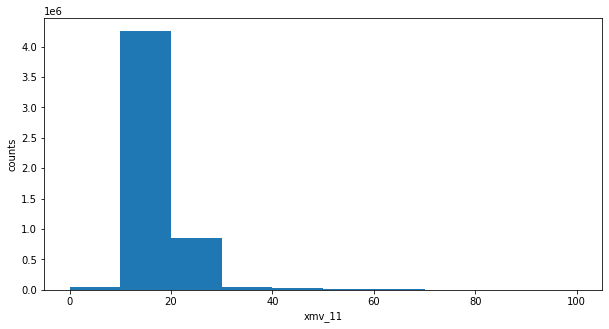

In [9]:
for col in raw_train.columns[3:]:
    plt.figure(figsize=(10,5))
    plt.hist(raw_train[col])
    plt.xlabel(col)
    plt.ylabel('counts')
    plt.show()

> ### Sampling

Described in "Data Preparation for Deep Learning Models" in [that article](https://medium.com/@mrunal68/tennessee-eastman-process-simulation-data-for-anomaly-detection-evaluation-d719dc133a7f)

In [10]:
%%time
# Program to construct the sample train data
frame = []

for i in set(raw_train['faultNumber']): 
    b_i = pd.DataFrame()
    if i == 0:
        b_i = raw_train[raw_train['faultNumber'] == i][0:20000]
        frame.append(b_i)
    else:
        fr = []
        b = raw_train[raw_train['faultNumber'] == i]
        for x in range(1,25):
            b_x = b[b['simulationRun'] == x][20:500]
            fr.append(b_x)
        
        b_i = pd.concat(fr)
    frame.append(b_i)      
    
sampled_train = pd.concat(frame)

CPU times: user 2.56 s, sys: 608 ms, total: 3.16 s
Wall time: 3.15 s


In [20]:
sampled_train.groupby('faultNumber')['simulationRun'].count() / raw_train.groupby('faultNumber')['simulationRun'].count()

faultNumber
0.0     0.16000
1.0     0.04608
2.0     0.04608
3.0     0.04608
4.0     0.04608
5.0     0.04608
6.0     0.04608
7.0     0.04608
8.0     0.04608
9.0     0.04608
10.0    0.04608
11.0    0.04608
12.0    0.04608
13.0    0.04608
14.0    0.04608
15.0    0.04608
16.0    0.04608
17.0    0.04608
18.0    0.04608
19.0    0.04608
20.0    0.04608
Name: simulationRun, dtype: float64

In [22]:
%%time
# Program to construct the sample CV Data
frame = []

for i in set(raw_train['faultNumber']):
    b_i = pd.DataFrame()
    if i == 0:
        b_i = raw_train[raw_train['faultNumber'] == i][20000:30000]
        frame.append(b_i)
    else:
        fr = []
        b = raw_train[raw_train['faultNumber'] == i]
        for x in range(26,35):
            b_x = b[b['simulationRun'] == x][20:500]
            fr.append(b_x)
        
        b_i = pd.concat(fr)  
    frame.append(b_i)
    
sampled_cv = pd.concat(frame)

CPU times: user 1.94 s, sys: 488 ms, total: 2.43 s
Wall time: 2.42 s


In [23]:
%%time
# Program to construct Sampled raw_test data
frame = []
for i in set(raw_test['faultNumber']):
    b_i = pd.DataFrame()
    if i == 0:
        b_i = raw_test[raw_test['faultNumber'] == i][0:2000]
        frame.append(b_i)
    else:
        fr = []
        b = raw_test[raw_test['faultNumber'] == i]
        for x in range(1,11):
            b_x = b[b['simulationRun'] == x][160:660]
            fr.append(b_x)
        b_i = pd.concat(fr)
    frame.append(b_i)      
    
sampled_test = pd.concat(frame)

CPU times: user 2.44 s, sys: 916 ms, total: 3.36 s
Wall time: 3.35 s


In [24]:
len(sampled_train), len(sampled_cv), len(sampled_test)

(270400, 106400, 104000)

In [25]:
sampled_data_path = "sampled_data/"

sampled_train.to_csv(sampled_data_path + "train.csv")
sampled_test.to_csv(sampled_data_path + "test.csv")
sampled_cv.to_csv(sampled_data_path + "cv.csv")

> ### Preparing data

In [31]:
#Sorting the Datasets wrt to the simulation runs
sampled_train.sort_values(['simulationRun', 'faultNumber'], inplace=True)
sampled_test.sort_values(['simulationRun', 'faultNumber'], inplace=True)
sampled_cv.sort_values(['simulationRun', 'faultNumber'], inplace=True)

In [32]:
# Removing faults 3, 9 and 15 
tr = sampled_train.drop(sampled_train[(sampled_train['faultNumber'] == 3) |\
                                      (sampled_train['faultNumber'] == 9) |\
                                      (sampled_train['faultNumber'] == 15)].index)

In [33]:
# Removing faults 3, 9 and 15 
ts = sampled_test.drop(sampled_test[(sampled_test['faultNumber'] == 3) |\
                                    (sampled_test['faultNumber'] == 9) |\
                                    (sampled_test['faultNumber'] == 15)].index)

In [34]:
# Removing faults 3, 9 and 15 
cv = sampled_cv.drop(sampled_cv[(sampled_cv['faultNumber'] == 3) |\
                                (sampled_cv['faultNumber'] == 9) |\
                                (sampled_cv['faultNumber'] == 15)].index)

In [ ]:
#converting the class labels to categorical values and removing unnecessary features from train, test and cv data.
y_train = to_categorical(tr['faultNumber'], num_classes=21)
y_test = to_categorical(ts['faultNumber'], num_classes=21)
y_cv = to_categorical(cv['faultNumber'], num_classes=21)

In [35]:
tr = tr.drop(['faultNumber', 'simulationRun', 'sample'], axis=1)
ts = ts.drop(['faultNumber', 'simulationRun', 'sample'], axis=1)
cv = cv.drop(['faultNumber', 'simulationRun', 'sample'], axis=1)

In [36]:
# Resizing the train, test and cv data.
x_train = np.array(tr)[:, :, np.newaxis]
x_test = np.array(ts)[:, :, np.newaxis]
x_cv = np.array(cv)[:, :, np.newaxis]

In [42]:
tr.shape, x_train.shape

((230080, 52), (230080, 52, 1))

In [44]:
tr

,xmeas_1,xmeas_2,xmeas_3,xmeas_4,xmeas_5,xmeas_6,xmeas_7,xmeas_8,xmeas_9,xmeas_10,...,xmv_2,xmv_3,xmv_4,xmv_5,xmv_6,xmv_7,xmv_8,xmv_9,xmv_10,xmv_11
0,0.25038,3674.0,4529.0,9.2320,26.889,42.402,2704.3,74.863,120.41,0.33818,...,53.744,24.657,62.544,22.137,39.935,42.323,47.757,47.510,41.258,18.447
1,0.25109,3659.4,4556.6,9.4264,26.721,42.576,2705.0,75.000,120.41,0.33620,...,53.414,24.588,59.259,22.084,40.176,38.554,43.692,47.427,41.359,17.194
2,0.25038,3660.3,4477.8,9.4426,26.875,42.070,2706.2,74.771,120.42,0.33563,...,54.357,24.666,61.275,22.380,40.244,38.990,46.699,47.468,41.199,20.530
3,0.24977,3661.3,4512.1,9.4776,26.758,42.063,2707.2,75.224,120.39,0.33553,...,53.946,24.725,59.856,22.277,40.257,38.072,47.541,47.658,41.643,18.089
4,0.29405,3679.0,4497.0,9.3381,26.889,42.650,2705.1,75.388,120.39,0.32632,...,53.658,28.797,60.717,21.947,39.144,41.955,47.645,47.346,41.507,18.461
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19995,0.27702,3691.3,4591.5,9.3989,27.140,42.126,2698.7,74.247,120.40,0.35448,...,53.724,27.169,59.533,21.632,42.770,35.577,47.876,47.183,40.636,18.305
19996,0.24602,3638.9,4522.8,9.3867,26.889,42.463,2696.3,75.415,120.40,0.32356,...,53.550,24.500,59.967,21.696,38.269,38.938,47.006,47.649,41.619,17.037
19997,0.24834,3687.0,4494.7,9.2960,26.573,42.270,2695.7,76.319,120.38,0.32474,...,53.886,24.271,60.624,21.841,38.126,34.708,43.143,48.051,40.422,20.756
19998,0.26879,3633.4,4534.2,9.4997,26.844,42.451,2697.5,75.073,120.40,0.32878,...,53.622,26.322,60.699,22.145,38.470,41.101,50.073,48.361,41.309,17.166


> ### Modeling: LSTM-1

#### Models configuration

In [26]:
model_1 = Sequential()
model_1.add(LSTM(256, input_shape=(52, 1), return_sequences=True))
model_1.add(LSTM(128, return_sequences=False))
model_1.add(Dense(300))
model_1.add(Dropout(0.5))
model_1.add(Dense(128))
model_1.add(Dense(21, activation='softmax'))
model_1.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model_1.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 52, 256)           264192    
_________________________________________________________________
lstm_2 (LSTM)                (None, 128)               197120    
_________________________________________________________________
dense_1 (Dense)              (None, 300)               38700     
_________________________________________________________________
dropout_1 (Dropout)          (None, 300)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 128)               38528     
_________________________________________________________________
dense_3 (Dense)              (None, 21)                2709      
Total params: 541,249
Trainable params: 541,249
Non-trainable params: 0
_________________________________________________________________
None

#### Training

In [27]:
n_epochs = 25
# n_epochs = 50

history_1 = model_1.fit(x_train, y_train, validation_data=(x_cv, y_cv), batch_size=256, epochs=n_epochs, verbose=2)

Train on 230080 samples, validate on 93440 samples
Epoch 1/25
 - 777s - loss: 1.7492 - acc: 0.4454 - val_loss: 1.2626 - val_acc: 0.6079
Epoch 2/25
 - 683s - loss: 1.2116 - acc: 0.6009 - val_loss: 1.1726 - val_acc: 0.6395
Epoch 3/25
 - 671s - loss: 1.1393 - acc: 0.6237 - val_loss: 1.1172 - val_acc: 0.6560
Epoch 4/25
 - 800s - loss: 1.1003 - acc: 0.6360 - val_loss: 1.0926 - val_acc: 0.6623
Epoch 5/25
 - 683s - loss: 1.0817 - acc: 0.6416 - val_loss: 1.0666 - val_acc: 0.6674
Epoch 6/25
 - 657s - loss: 1.0652 - acc: 0.6469 - val_loss: 1.0530 - val_acc: 0.6737
Epoch 7/25
 - 646s - loss: 1.0457 - acc: 0.6540 - val_loss: 1.0447 - val_acc: 0.6799
Epoch 8/25
 - 638s - loss: 1.0177 - acc: 0.6623 - val_loss: 1.0391 - val_acc: 0.6787
Epoch 9/25
 - 640s - loss: 0.9945 - acc: 0.6698 - val_loss: 1.0131 - val_acc: 0.6859
Epoch 10/25
 - 639s - loss: 0.9769 - acc: 0.6791 - val_loss: 1.0727 - val_acc: 0.6706
Epoch 11/25
 - 639s - loss: 0.9706 - acc: 0.6808 - val_loss: 1.0361 - val_acc: 0.6753
Epoch 12/25


#### Metrics

In [28]:
history_1.history

{'val_loss': [1.2626240880128647,
  1.1725907097827746,
  1.1171926342533967,
  1.0925510261701261,
  1.0666467783584752,
  1.0530198055912117,
  1.044705560506064,
  1.0390577485607306,
  1.0131441320554855,
  1.0727203462979795,
  1.0361078953948002,
  1.2099201416407073,
  0.9642697714776995,
  0.9733062689929567,
  0.8781808541543746,
  0.7926087839405598,
  0.8086971929647672,
  0.8741308636696614,
  0.7691770783325251,
  0.8173308804150798,
  0.8563362626781394,
  0.7728852251136072,
  0.7883462497561421,
  0.9522524365471905,
  0.7577314527188742],
 'val_acc': [0.6079302226027398,
  0.6395440924657534,
  0.6559717465753425,
  0.6623287671232877,
  0.6673587328767123,
  0.6737371575342466,
  0.6798694349315069,
  0.6786708047945206,
  0.6859267979452055,
  0.6705586472602739,
  0.6752996575342466,
  0.6435573630136986,
  0.7093642979452055,
  0.7068493150684931,
  0.7370933219178082,
  0.7631207191780822,
  0.7601455479452055,
  0.7432898116438356,
  0.774486301369863,
  0.756763

In [41]:
def plots_and_metrics(h, m):

    epochs_arr = list(range(1, len(h.history['acc']) + 1))
    
    # Plot training & validation accuracy values
    plt.figure(figsize=(20,5))
    plt.plot(epochs_arr, h.history['acc'])
    plt.plot(epochs_arr, h.history['val_acc'])
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.xticks(epochs_arr)
    plt.legend(['Train', 'Test'], loc='upper left')
    plt.show()

    # Plot training & validation loss values
    plt.figure(figsize=(20,5))
    plt.plot(epochs_arr, h.history['loss'])
    plt.plot(epochs_arr, h.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.xticks(epochs_arr)
    plt.legend(['Train', 'Test'], loc='upper left')
    plt.show()

    score, accuracy = m.evaluate(x_test, y_test, verbose=0)
    print('Test accuracy:', accuracy)
    print("Test loss:", score)

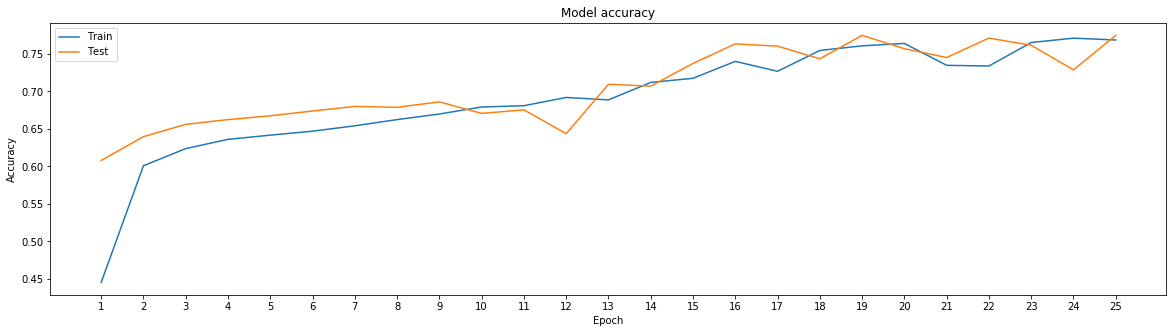

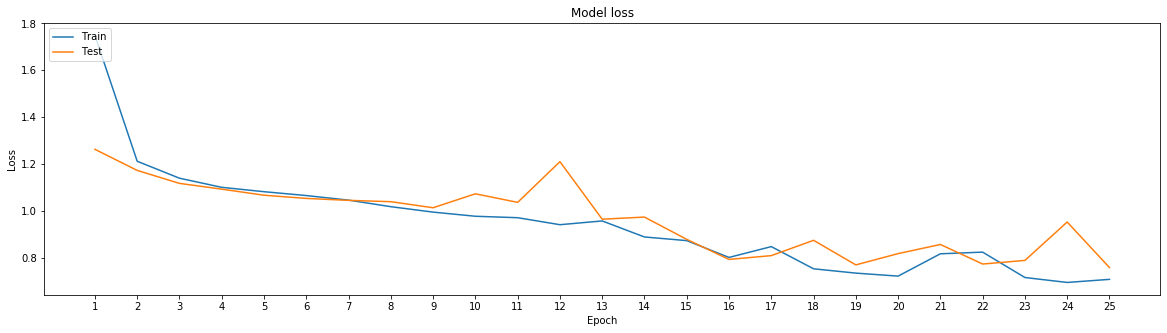

Test accuracy: 0.7377078651685394
Test loss: 0.8329766244701989
CPU times: user 4min 58s, sys: 23 s, total: 5min 21s
Wall time: 1min 45s


In [42]:
%%time

plots_and_metrics(history_1, model_1)

> ### Modeling: LSTM-2

In [34]:
model_2 = Sequential()
model_2.add(LSTM(128, input_shape=(52, 1), return_sequences=False))
model_2.add(Dense(300))
model_2.add(Dropout(0.5))
model_2.add(Dense(128))
model_2.add(Dense(21, activation='softmax'))
model_2.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model_2.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_4 (LSTM)                (None, 128)               66560     
_________________________________________________________________
dense_7 (Dense)              (None, 300)               38700     
_________________________________________________________________
dropout_3 (Dropout)          (None, 300)               0         
_________________________________________________________________
dense_8 (Dense)              (None, 128)               38528     
_________________________________________________________________
dense_9 (Dense)              (None, 21)                2709      
Total params: 146,497
Trainable params: 146,497
Non-trainable params: 0
_________________________________________________________________
None


#### Training

In [35]:
n_epochs = 3
n_epochs = 50

history_2 = model_2.fit(x_train, y_train, validation_data = (x_cv, y_cv), batch_size=256, epochs=n_epochs, verbose=2)

Train on 230080 samples, validate on 93440 samples
Epoch 1/50
 - 129s - loss: 1.8608 - acc: 0.4174 - val_loss: 1.5097 - val_acc: 0.5491
Epoch 2/50
 - 126s - loss: 1.3767 - acc: 0.5593 - val_loss: 1.3313 - val_acc: 0.5970
Epoch 3/50
 - 127s - loss: 1.2526 - acc: 0.5954 - val_loss: 1.4297 - val_acc: 0.5565
Epoch 4/50
 - 127s - loss: 1.1557 - acc: 0.6317 - val_loss: 1.1099 - val_acc: 0.6701
Epoch 5/50
 - 127s - loss: 1.0390 - acc: 0.6703 - val_loss: 1.0263 - val_acc: 0.7048
Epoch 6/50
 - 128s - loss: 0.9635 - acc: 0.6920 - val_loss: 0.9132 - val_acc: 0.7278
Epoch 7/50
 - 128s - loss: 0.9214 - acc: 0.7043 - val_loss: 0.9526 - val_acc: 0.7220
Epoch 8/50
 - 129s - loss: 0.8746 - acc: 0.7172 - val_loss: 0.8725 - val_acc: 0.7428
Epoch 9/50
 - 130s - loss: 0.8656 - acc: 0.7198 - val_loss: 1.0994 - val_acc: 0.6725
Epoch 10/50
 - 131s - loss: 0.8445 - acc: 0.7251 - val_loss: 0.8970 - val_acc: 0.7390
Epoch 11/50
 - 132s - loss: 0.8258 - acc: 0.7308 - val_loss: 0.8235 - val_acc: 0.7504
Epoch 12/50


#### Metrics

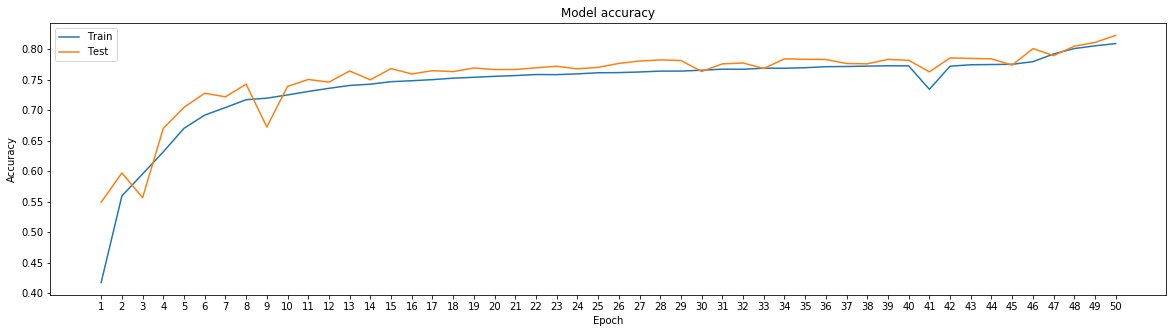

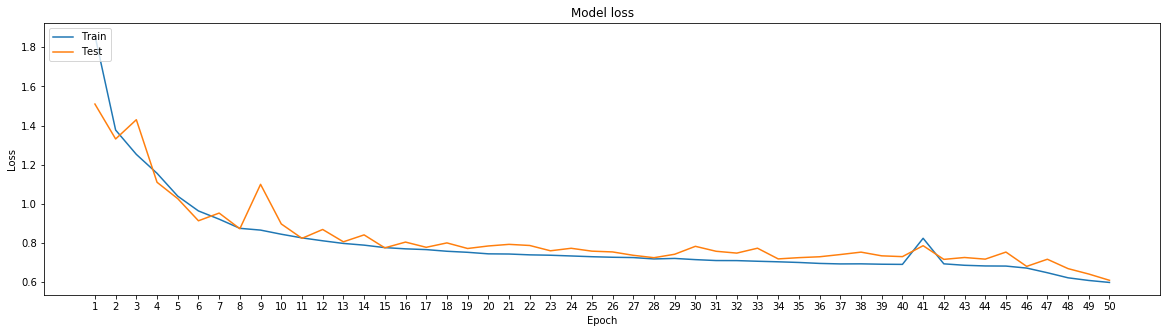

Test accuracy: 0.7909775280898876
Test loss: 0.6811320982670518
CPU times: user 59 s, sys: 7.05 s, total: 1min 6s
Wall time: 26.6 s


In [43]:
%%time

plots_and_metrics(history_2, model_2)